### Goal:
Use Dempster-Shafer theory to make consensus predictions on blood-brain barrier penetration

#### Load libraries

In [26]:
from pip._internal import main as pip

import dst

try:
    import pandas as pd
except ImportError:
    pip(['install', 'pandas'])
    import pandas as pd
       
try:
    import numpy as np
    from numpy.ma import masked_array
except ImportError:
    pip(['install', 'numpy'])
    import numpy as np
    from numpy.ma import masked_array

try:
    import sklearn
    from sklearn.metrics import confusion_matrix
except ImportError:
    pip(['install', 'sklearn'])
    import sklearn
    from sklearn.metrics import confusion_matrix

try:
    import matplotlib.pyplot as plt
except ImportError:
    pip(['install', 'matplotlib'])
    import matplotlib.pyplot as plt

#### Load datasets and compute PPV, NPV for each predictive model (unless they are already provided and stated in the next cell)

In [27]:
models = ['CPSign', 'Jaqpot', 'Lazar', 'Weka', 'OChem']

# dictionary to collect PPV, NPV values of individual models
models_ppv = {}
models_npv = {}
models_data = {}

# loop over models and compute PPV, NPV for each
for model in models:
    filename = 'predictions_' + model + '.csv'
    df = pd.read_csv(filename)
    
    # remove NaN containing rows
    df = df.dropna(axis=0, how='any')

    # remove rows with duplicated Smiles
    df = df.drop_duplicates(subset='SMILES')
    
    tn, fp, fn, tp = confusion_matrix(df['True'], df['Predicted']).ravel()
    
    models_ppv[model] = tp / (tp + fp)
    models_npv[model] = tn / (tn + fn)
    models_data[model] = df

In [28]:
models_ppv, models_npv

({'CPSign': 0.80555555555555558,
  'Jaqpot': 0.86415094339622645,
  'Lazar': 0.76512455516014233,
  'Weka': 0.90877192982456145,
  'OChem': 0.86090225563909772},
 {'CPSign': 0.69827586206896552,
  'Jaqpot': 0.78761061946902655,
  'Lazar': 0.68965517241379315,
  'Weka': 0.92436974789915971,
  'OChem': 0.71739130434782605})

In [29]:
models_npv['Lazar'] = 0.489
models_ppv['Lazar'] = 0.886

#### Find common compounds to all datasets

In [43]:
# make a list of lists, which contain SMILES of compounds in that particular model
compound_list_all = []

for model in models:
    compound_list_all.append(models_data[model]['SMILES'].tolist())
    
# convert list of lists to list of sets
compound_sets = map(set, compound_list_all)

# perform intersection on each set in the list
common_items = set.intersection(*compound_sets)
common_items = list(common_items)

#### Loop over compounds and make DST prediction for each

In [31]:
# initiate list of dictionaries to collect results
results_Yager, results_Dempster = [], []

# compounds loop
for compound in common_items:
    models_pred, models_prob, dy, dd = {}, {}, {}, {}

    dy['SMILES'] = compound
    dd['SMILES'] = compound
    
    dy['True'] = models_data[models[0]].set_index('SMILES').loc[compound, :].to_dict()['True']
    dd['True'] = models_data[models[0]].set_index('SMILES').loc[compound, :].to_dict()['True']
    
    # collect required inputs for each model
    for model in models:
        pred = models_data[model].set_index('SMILES').loc[compound, :].to_dict()['Predicted']
        
        if pred == 'penetrating':
            # penetrating
            models_pred[model] = 'P'
            
            if (model == 'Weka') or (model == 'Lazar') or (model == 'OChem'):
                models_prob[model] = 1
            elif (model == 'CPSign') or (model == 'Jaqpot'):
                models_prob[model] = models_data[model].set_index('SMILES').loc[compound, :].to_dict()['Probability_P']
            
            # probability of positive prediction
            dy[model] = models_prob[model]
            dd[model] = models_prob[model]
        else:
            # non-penetrating
            models_pred[model] = 'N'

            if (model == 'Weka') or (model == 'Lazar') or (model == 'OChem'):
                models_prob[model] = 1
            elif (model == 'CPSign') or (model == 'Jaqpot'):
                models_prob[model] = models_data[model].set_index('SMILES').loc[compound, :].to_dict()['Probability_N']
            
            # probability of positive prediction
            dy[model] = 1 - models_prob[model]
            dd[model] = 1 - models_prob[model]
            
    bel, pls, res = dst.predict_Yager(models_pred, models_prob, models_ppv, models_npv)
    
    dy['Bel_P'] = bel['P']
    dy['Bel_N'] = bel['N']
    dy['Uncertainty'] = pls['P'] - bel['P']

    results_Yager.append(dy)
    
    bel, pls, res = dst.predict_Dempster(models_pred, models_prob, models_ppv, models_npv)
    
    dd['Bel_P'] = bel['P']
    dd['Bel_N'] = bel['N']
    dd['Uncertainty'] = pls['P'] - bel['P']
   
    results_Dempster.append(dd)

df_Yager = pd.DataFrame(results_Yager)
df_Dempster = pd.DataFrame(results_Dempster)

orderedCols = ['SMILES', 'True'] + models + ['Bel_P', 'Bel_N', 'Uncertainty']

df_Yager = df_Yager[orderedCols]
df_Dempster = df_Dempster[orderedCols]

df_Yager.to_csv('predictions_consensus_Yager.csv', index=False)
df_Dempster.to_csv('predictions_consensus_Dempster.csv', index=False)

#### Generate heatmaps

In [53]:
# drop unneccessary columns
arr = df_Dempster.drop(['SMILES', 'True'], axis=1)

# convert dataframe to array
arr = arr.round(2).values

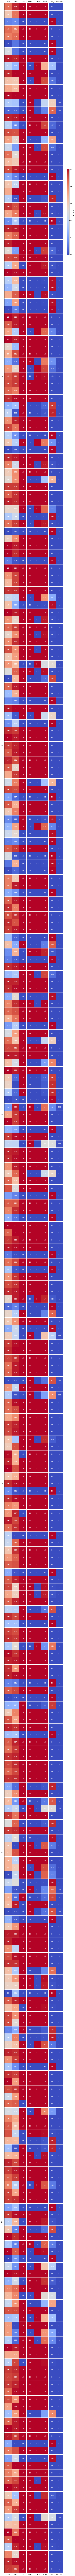

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 900))

yCols = models + ['Cons_P', 'Cons_N', 'Uncertainty']

ax.set_xticks(np.arange(arr.shape[1]))
ax.set_xticklabels(yCols)
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)

ax.set_xticks(np.arange(arr.shape[1] + 1) + 0.5, minor=True)
ax.set_yticks(np.arange(arr.shape[0] + 1) - 0.5, minor=True)

ax.grid(which='minor', color="w", linestyle='-', linewidth=2)

im = ax.imshow(arr, cmap='coolwarm', vmin=0, vmax=1)

#cbaxes = fig.add_axes([0.95, 0.69, 0.03, 0.01]) # for 3 models
#cbaxes = fig.add_axes([0.95, 0.663, 0.03, 0.01]) # for 4 models
cbaxes = fig.add_axes([0.95, 0.623, 0.03, 0.01]) # for 5 models

cb = plt.colorbar(im, cax = cbaxes)

cb.set_label('Probability')

for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        text = ax.text(j, i, arr[i, j], ha="center", va="center", color="w")
#fig.tight_layout()
#plt.show()

fig.savefig('heatmap.png')

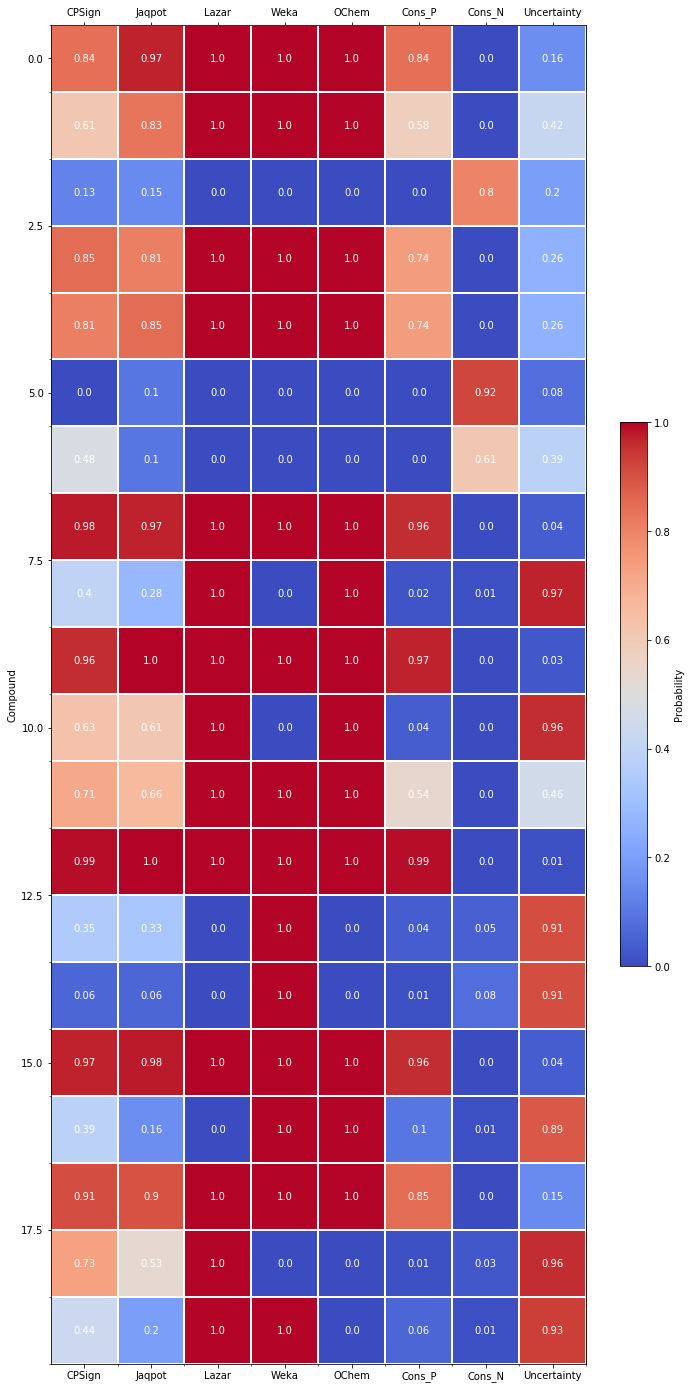

In [38]:
# drop unneccessary columns
arr = df_Yager.drop(['SMILES', 'True'], axis=1)

# convert dataframe to array
arr = arr.round(2).values

arr = arr[0 : 20]
fig, ax = plt.subplots(1, 1, figsize=(12, 25))

yCols = models + ['Cons_P', 'Cons_N', 'Uncertainty']

ax.set_xticks(np.arange(arr.shape[1]))
ax.set_xticklabels(yCols)
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)

ax.set_xticks(np.arange(arr.shape[1] + 1) + 0.5, minor=True)
ax.set_yticks(np.arange(arr.shape[0] + 1) - 0.5, minor=True)

ax.set_ylabel('Compound')

ax.grid(which='minor', color="w", linestyle='-', linewidth=2)

im = ax.imshow(arr, cmap='coolwarm', vmin=0, vmax=1)

#cbaxes = fig.add_axes([0.95, 0.69, 0.03, 0.01]) # for 3 models
#cbaxes = fig.add_axes([0.95, 0.663, 0.03, 0.01]) # for 4 models

#cb = plt.colorbar(im, cax = cbaxes)
cb = plt.colorbar(im, shrink=0.4)

cb.set_label('Probability')

for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        text = ax.text(j, i, arr[i, j], ha="center", va="center", color="w")
#fig.tight_layout()
#plt.show()

fig.savefig('heatmap_Y.png')

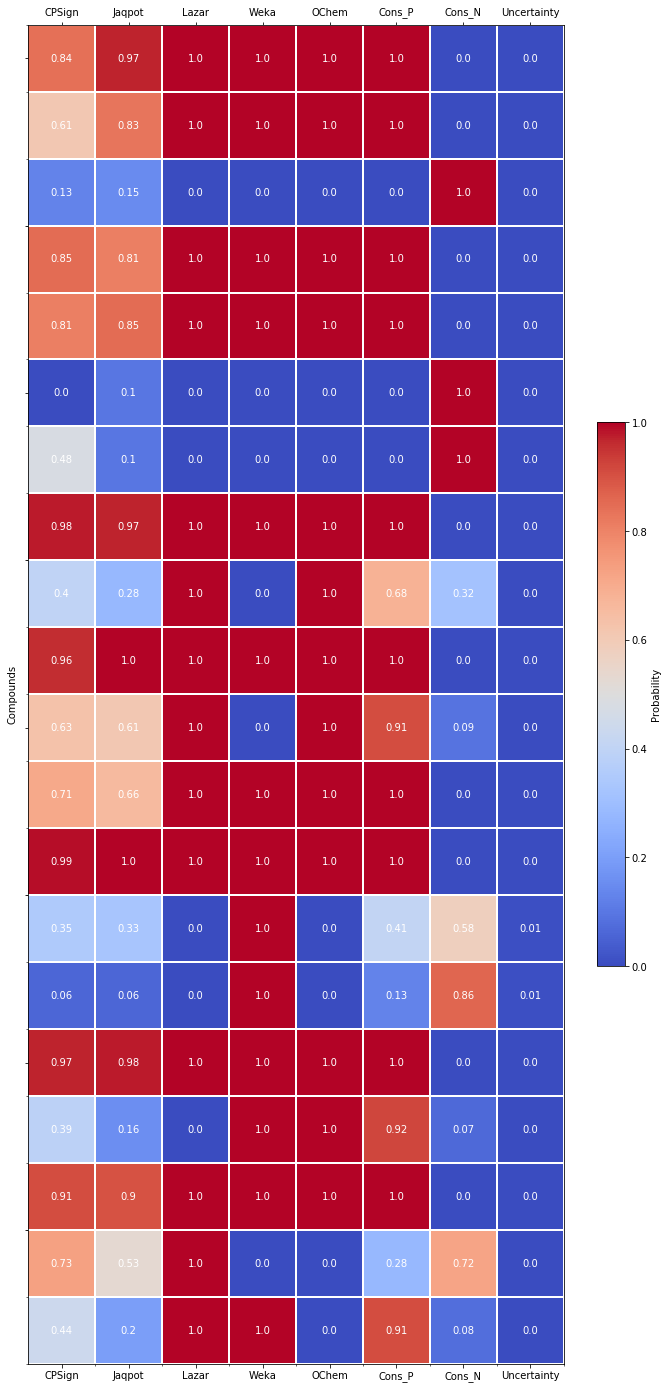

In [39]:
# drop unneccessary columns
arr = df_Dempster.drop(['SMILES', 'True'], axis=1)

# convert dataframe to array
arr = arr.round(2).values

arr = arr[0 : 20]
fig, ax = plt.subplots(1, 1, figsize=(12, 25))

yCols = models + ['Cons_P', 'Cons_N', 'Uncertainty']

ax.set_xticks(np.arange(arr.shape[1]))
ax.set_xticklabels(yCols)
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)

ax.set_xticks(np.arange(arr.shape[1] + 1) + 0.5, minor=True)
ax.set_yticks(np.arange(arr.shape[0] + 1) - 0.5, minor=True)
ax.set_yticklabels('')
ax.set_ylabel('Compounds')

ax.grid(which='minor', color="w", linestyle='-', linewidth=2)

im = ax.imshow(arr, cmap='coolwarm', vmin=0, vmax=1)

#cbaxes = fig.add_axes([0.95, 0.69, 0.03, 0.01]) # for 3 models
#cbaxes = fig.add_axes([0.95, 0.663, 0.03, 0.01]) # for 4 models

#cb = plt.colorbar(im, cax = cbaxes)
cb = plt.colorbar(im, shrink=0.4)

cb.set_label('Probability')

for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        text = ax.text(j, i, arr[i, j], ha="center", va="center", color="w")
#fig.tight_layout()
#plt.show()

fig.savefig('heatmap_D.png')